### This notebook creates 4 CSV files with $n$ rows and  $(h * w) + 1$ columns each, where $n$ is the number of pictures per image set and $h$ and $w$ are height and width of a picture. The first $h * w$ cells of the $n$th row contain the mean of the RGB value of a pixel of the $n$th picture of the respective image set. The last column contains the labels of the respective images.

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
from PIL import Image

% matplotlib inline

WIDTH, HEIGHT = 240, 240
DATA_DIR = os.path.join("..", "data")

# HGG_OUTPUT_CSV = 'week3_hgg.csv'
# LGG_OUTPUT_CSV = 'week3_lgg.csv'
OUTPUT_CSV = 'week3_just_tumor.csv'

# Ground truth
# HGG_GT_TXT = '/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/list/HGG_GT.txt'
# LGG_GT_TXT = '/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/list/LGG-GT.txt'

# 
# HGG_IMG_TXT = '/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/list/HGG-img.txt'
# LGG_IMG_TXT = '/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/list/LGG-img.txt'

HGG_IMG_TXT = os.path.abspath('GTnonzeroHgg.txt')
LGG_IMG_TXT = os.path.abspath('GTnonzeroLgg.txt')

In [3]:
def get_paths(path):
    csv_file = os.path.abspath(path)
    with open(csv_file) as f:
        data_file = f.read().splitlines()
    return [x.split(' ,') for x in data_file if len(x) > 0 and len(x.split(' ,')) == 2]

In [82]:
lgg_set = [('/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/LGG/Png-LGG/' + x, l) for x, l in get_paths(LGG_IMG_TXT)]
hgg_set = [('/mnt/naruto/Seminar-Med-Seg2017/BRATS2017/HGG/Png-HGG/' + x, l) for x, l in get_paths(HGG_IMG_TXT)]
print('{} lgg images'.format(len(lgg_set)))  # 16876 [190500]
print('{} hgg images'.format(len(hgg_set)))  # 48384 [533400]
dataset = lgg_set + hgg_set
# dataset2 = lgg_set[:5000] + hgg_set[:5000]
# Stichprobenartig checken, ob ein Bild existiert
for p, _ in dataset[::20]:
    assert os.path.isfile(p), p

16876 lgg images
48384 hgg images


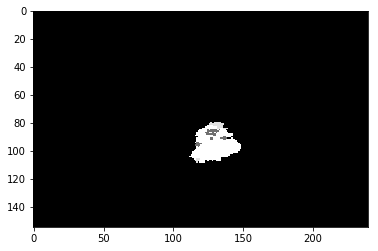

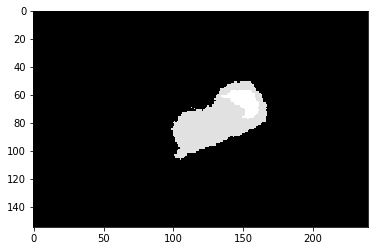

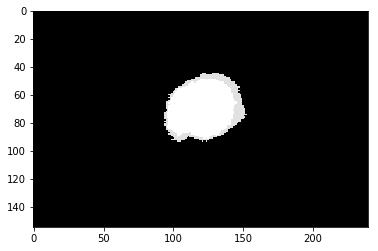

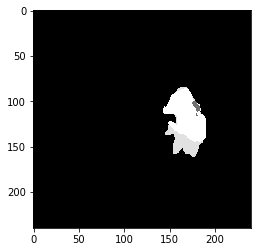

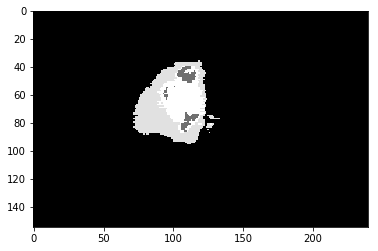

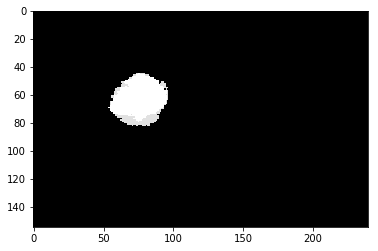

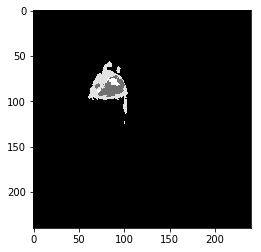

In [98]:
for p, _ in dataset[10:2000:300]:
    show_image(p)

In [101]:
def png_to_matrix(path, resize=True):
    # Convert image to matrix
    png = Image.open(path)
    png.load() # required for png.split()
    img = np.array(png)
    if len(img.shape) == 3:
        # Turn RGB into grayscaled image
        img = np.mean(img, axis=2)
    if resize and img.shape != (WIDTH, HEIGHT):
        h, w = img.shape
        assert w == 240 and h == 155, '{}, {}, {}'.format(w, h, path)
        img = np.concatenate([np.zeros((42, 240)), img, np.zeros((43, 240))])
    return img.astype(np.uint8)  

def show_image(path, resize=False, ax=None):
    # print(path)
    img = png_to_matrix(path, resize)
    # print("Image matrix shape:", img.shape)
    if ax:
        ax.imshow(img, cmap='gray')
    else:
        plt.imshow(img, cmap='gray')
        plt.show()

def prepare_output_file(file):
    columns = [str(x) for x in range(WIDTH * HEIGHT)] + ['label']
    df = pd.DataFrame([], columns=columns, dtype=np.uint8)
    df.to_csv(file, index=False)
    
def convert_images_to_csv():
    csv_output = os.path.join(DATA_DIR, OUTPUT_CSV)
    prepare_output_file(csv_output)
    data = dataset
    # Test png_to_matrix with a picture
    show_image(data[0][0])
    # Build dataframe with X and y
    print('Preprocessing', end='')
    content = ''
    count_black = 0
    for i, path, label in zip(range(len(data)), *zip(*data)):
        try:
            img = png_to_matrix(path).reshape([-1])
            # Do not store blank images (everything black)
            if img.sum() > 0:
                content += ','.join([str(x) for x in img]) + ',{}\n'.format(label)
            else:
                count_black += 1
            if (i % 500 == 0 and i != 0) or i == len(data) - 1:
                # Only open stream after a few hundred steps due to performance
                with open(csv_output, 'a') as f:
                    f.write(content)
                content = ''
                print('.', end='')
            if (i % 2000 == 0 and i != 0):
                print(i, count_black)
                count_black = 0
        except Exception as e:
            img_id = '.'.join(path.split('/')[-1].split('.')[:-1])
            print(img_id + ': ' + str(e))
            print('Failed')
            return -1
    print('Done')
    return csv_output

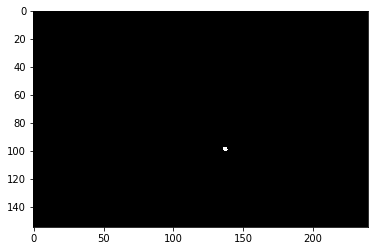

Preprocessing....2000 60
....4000 205
....6000 345
....8000 423
....10000 410
....12000 369
....14000 337
....16000 231
....18000 193
....20000 0
....22000 107
....24000 403
....26000 428
....28000 288
....30000 415
....32000 362
....34000 469
....36000 360
....38000 267
....40000 500
....42000 444
.

In [ ]:
output_file = convert_images_to_csv()

In [ ]:
pd.read_csv(os.path.join(DATA_DIR, OUTPUT_CSV), index_col=False)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import utils
from tensorflow.python.client import device_lib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Nadam
from matplotlib import pyplot as plt
%matplotlib inline
device_lib.list_local_devices()

SOURCE_FILE = os.path.join('..', 'data', OUTPUT_CSV)

In [ ]:
def preprocess_dataset(dataset):
    # Pop labels and transform them to vectors
    y = dataset.pop('label')
    y = y.values.reshape((-1, 1))
    # Reshape the features for CNN
    X = dataset.as_matrix().reshape(dataset.shape[0], 1, WIDTH, HEIGHT).astype(np.float32)
    # Norm data
    X /= 255
    # Convert labels to categorical values
    y = keras.utils.to_categorical(y, 2)
    return X, y

def get_shuffled_splitted_data(path=SOURCE_FILE):
    df = pd.read_csv(path)
    # Shuffle and split data into: 70% train, 20% test, 10% validation
    train, test, val = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])    
    # Extract labels, normalize, preprocess for keras
    X_train, y_train = preprocess_dataset(train)
    X_test, y_test = preprocess_dataset(test)
    X_val, y_val = preprocess_dataset(val)
    return X_train, y_train, X_test, y_test, X_val, y_val

# Collect new dataset containing sagittal images including scull and tumor
X_train, y_train, X_test, y_test, X_val, y_val = get_shuffled_splitted_data()

In [ ]:
def setup_model():
    model = Sequential()
    # model.add(Cropping2D(cropping=((0, 0), (62, 61)), input_shape=(1, WIDTH, HEIGHT)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(1, WIDTH, HEIGHT)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Removing the second Conv & MaxPooling layer ends up in 50% accuracy
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
                  optimizer=Nadam(),
                  metrics=['accuracy'])
    return model

with tf.device('/gpu:0'):
    K.set_image_dim_ordering('th')
    batch_size = 32
    num_classes = 2
    epochs = 3
    # For storing the validation loss values
    history = keras.callbacks.History()
    # Train model
    model = setup_model()
    model_results = model.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[history])
    # Evaluate model on validation set
    print('\nValidate model on {} unknown validation samples:'.format(X_val.shape[0]))
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print('Val loss:', val_score[0])
    print('Val accuracy:', val_score[1])